# Multilayer Perceptrons for Regression

**This notebook shows how to create a MLP regression model with TensorFlow 2 and Keras**

## The Data

We will be using the California Housing Prices dataset from Kaggle:

https://www.kaggle.com/camnugent/california-housing-prices

**Information**

This is the dataset used in the second chapter of Aurélien Géron's recent book 'Hands-On Machine learning with Scikit-Learn and TensorFlow'. It serves as an excellent introduction to implementing machine learning algorithms because it requires rudimentary data cleaning, has an easily understandable list of variables and sits at an optimal size between being to toyish and too cumbersome.

The data contains information from the 1990 California census. So although it may not help you with predicting current housing prices like the Zillow Zestimate dataset, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

**Attributes**

1. **longitude**: A measure of how far west a house is; a higher value is farther west
2. **latitude**: A measure of how far north a house is; a higher value is farther north
3. **housingMedianAge**: Median age of a house within a block; a lower number is a newer building
4. **totalRooms**: Total number of rooms within a block
5. **totalBedrooms**: Total number of bedrooms within a block
6. **population**: Total number of people residing within a block
7. **households**: Total number of households, a group of people residing within a home unit, for a block
8. **medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. **medianHouseValue**: Median house value for households within a block (measured in US Dollars)
10. **oceanProximity**: Location of the house w.r.t ocean/sea

## Table of Contents
- ### [Python libraries](#libraries)
- ### [Data Exploration and Feature Engineering](#exploration)
- ### [Split the Data](#split)
- ### [Normalize the Data](#normalize)
- ### [Create the Model](#model)
- ### [Train the Model](#training)
- ### [Evaluate the Model](#evaluation)
- ### [Predictions](#predictions)

<a id='libraries'></a>
## Python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

<a id='exploration'></a>
## Data Exploration and Feature Engineering

**Read the data**

In [2]:
df = pd.read_csv('../../Data/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Check for null values**

In [3]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Drop rows with null values

In [6]:
df.dropna(inplace=True)

**Attribute statistics**

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
longitude,20433.0,-119.570689,2.003578,-124.3500,-121.8000,-118.4900,-118.010,-114.3100
latitude,20433.0,35.633221,2.136348,32.5400,33.9300,34.2600,37.720,41.9500
housing_median_age,20433.0,28.633094,12.591805,1.0000,18.0000,29.0000,37.000,52.0000
total_rooms,20433.0,2636.504233,2185.269567,2.0000,1450.0000,2127.0000,3143.000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.000,6445.0000
population,20433.0,1424.946949,1133.208490,3.0000,787.0000,1166.0000,1722.000,35682.0000
households,20433.0,499.433465,382.299226,1.0000,280.0000,409.0000,604.000,6082.0000
median_income,20433.0,3.871162,1.899291,0.4999,2.5637,3.5365,4.744,15.0001
median_house_value,20433.0,206864.413155,115435.667099,14999.0000,119500.0000,179700.0000,264700.000,500001.0000


**Spatial distribution**

In [8]:
gdf = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000)
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22000 37.86000)
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24000 37.85000)
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25000 37.85000)
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25000 37.85000)


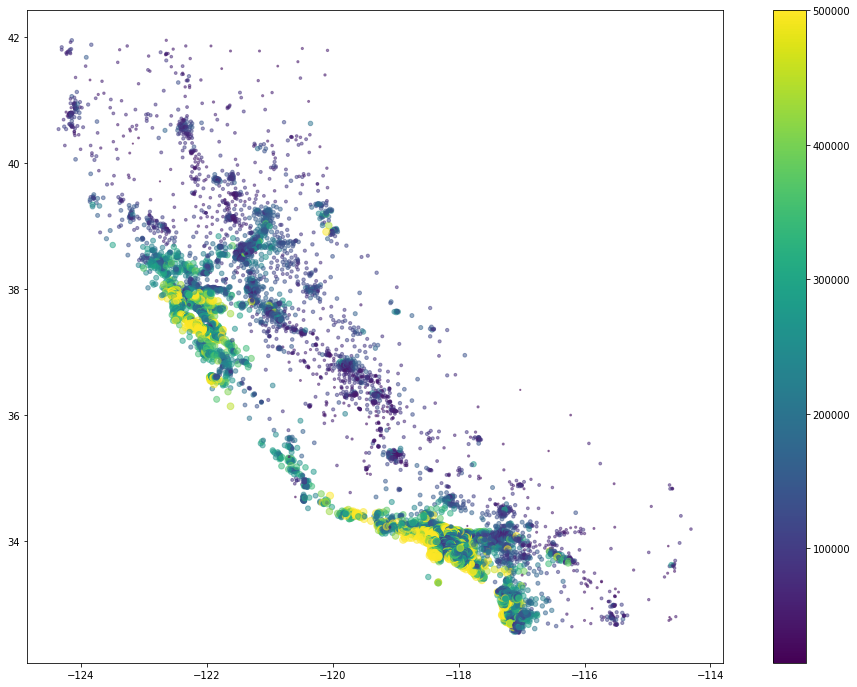

In [9]:
fig, ax = plt.subplots(figsize=(18,12))
gdf.plot(ax=ax,column='median_house_value', markersize=gdf['median_house_value']*1e-4, alpha=0.5, legend=True)

**Distribution of output variable (median house value)**

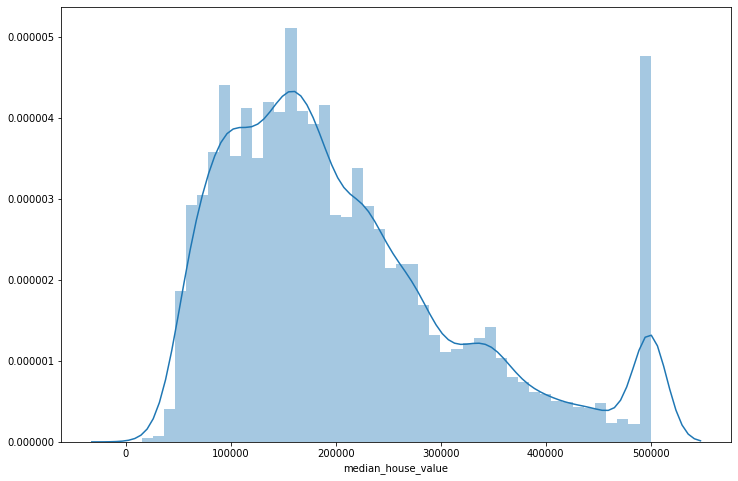

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(df['median_house_value'])

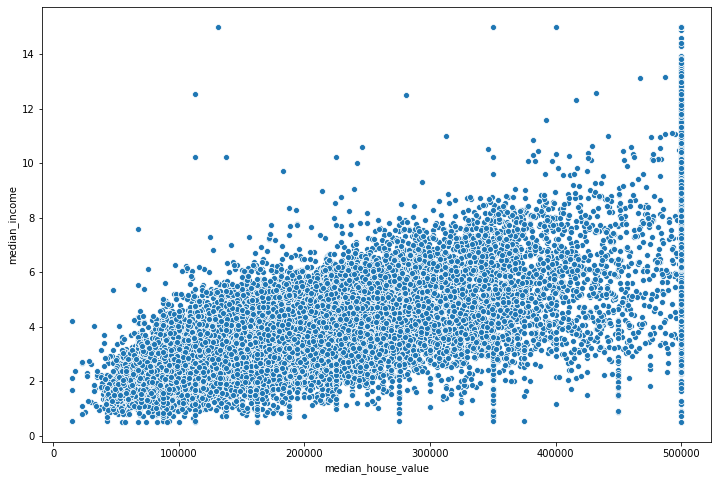

In [11]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='median_house_value',y='median_income',data=df)

Remove values >= 500000$

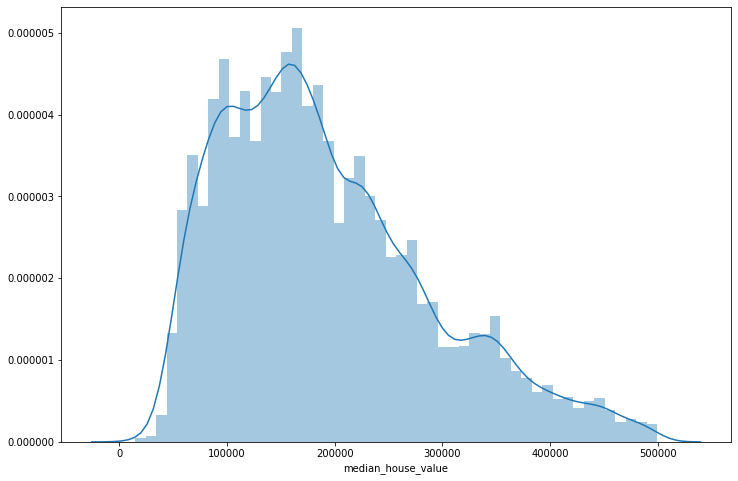

In [12]:
df = df[df['median_house_value'] < 500000]

plt.figure(figsize=(12,8))
sns.distplot(df['median_house_value'])

**Categorical data**

In [13]:
categories = list(df['ocean_proximity'].unique())
print(categories)

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']


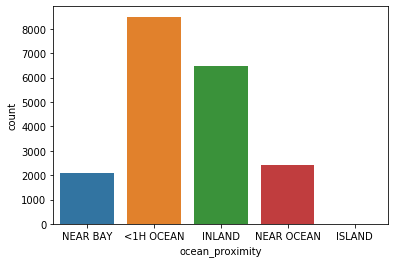

In [14]:
sns.countplot(df['ocean_proximity'])

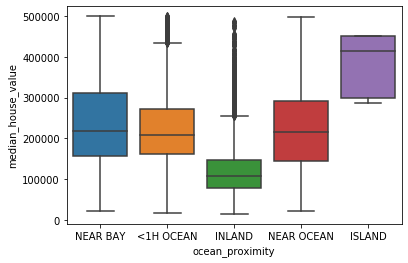

In [15]:
sns.boxplot(x='ocean_proximity',y='median_house_value',data=df)

Converting categorical data into numbers

In [16]:
dict_cat = dict(zip(categories, np.arange(df['ocean_proximity'].nunique())))
dict_cat

{'NEAR BAY': 0, '<1H OCEAN': 1, 'INLAND': 2, 'NEAR OCEAN': 3, 'ISLAND': 4}

In [17]:
df['ocean_proximity'] = df['ocean_proximity'].apply(lambda x: dict_cat[x])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19448 entries, 0 to 20639
Data columns (total 10 columns):
longitude             19448 non-null float64
latitude              19448 non-null float64
housing_median_age    19448 non-null float64
total_rooms           19448 non-null float64
total_bedrooms        19448 non-null float64
population            19448 non-null float64
households            19448 non-null float64
median_income         19448 non-null float64
median_house_value    19448 non-null float64
ocean_proximity       19448 non-null int64
dtypes: float64(9), int64(1)
memory usage: 2.3 MB


<a id='split'></a>
## Split the Data

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X = df.drop('median_house_value',axis=1)
y = df['median_house_value']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [22]:
X_train.shape

(13613, 9)

In [23]:
y_train.shape

(13613,)

<a id='normalize'></a>
## Normalize the Data

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler()

In [26]:
X_train = scaler.fit_transform(X_train)

In [27]:
X_test = scaler.transform(X_test)

<a id='model'></a>
## Create the Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [31]:
model = Sequential()

model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam', loss='mse')

<a id='training'></a>
## Train the Model

In [32]:
model.fit(x=X_train, y=y_train.values, 
          validation_data=(X_test,y_test.values),
          epochs=500,
          batch_size=128)

Train on 13613 samples, validate on 5835 samples
Epoch 1/500
13613/13613 [==============================] - 1s 69us/sample - loss: 45949140076.3952 - val_loss: 47105492453.9393
Epoch 2/500
13613/13613 [==============================] - 0s 12us/sample - loss: 45918523145.5720 - val_loss: 47004558190.8675
Epoch 3/500
13613/13613 [==============================] - 0s 16us/sample - loss: 45528864076.4070 - val_loss: 46067530021.7748
Epoch 4/500
13613/13613 [==============================] - 0s 14us/sample - loss: 43290790764.3388 - val_loss: 41816166244.8644
Epoch 5/500
13613/13613 [==============================] - 0s 15us/sample - loss: 36115305411.4461 - val_loss: 31069310742.2437
Epoch 6/500
13613/13613 [==============================] - 0s 13us/sample - loss: 23151981617.4210 - val_loss: 16843344769.1188
Epoch 7/500
13613/13613 [==============================] - 0s 12us/sample - loss: 12324310464.8510 - val_loss: 10280439803.2617
Epoch 8/500
13613/13613 [==============================

**Save the model**

In [57]:
#model.save('regression_model.h5')

**Load the model**

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#model = load_model('regression_model.h5')

<a id='evaluation'></a>
## Evaluate the Model
Check common regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

In [33]:
from sklearn.metrics import mean_squared_error, explained_variance_score

####  Training and validation losses

We can compare these two variables to check for overfitting.

In [34]:
losses = pd.DataFrame(model.history.history)

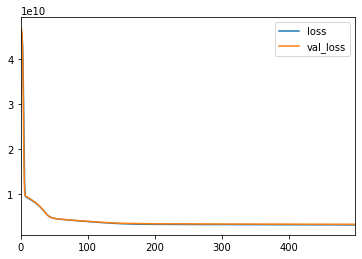

In [35]:
losses.plot()

#### Compare predictions with the real test labels

**Root mean square error**

In [36]:
test_predictions = model.predict(X_test)

In [37]:
rmse = np.sqrt(mean_squared_error(y_test,test_predictions))
print('Root mean square error:', rmse)

Root mean square error: 57526.98116103994


In [38]:
df['median_house_value'].mean()

192017.66742081448

In [39]:
df['median_house_value'].median()

173700.0

In [40]:
rmse/df['median_house_value'].mean()*100

29.959212573375986

**Explained variance score**

The best possible score is 1.0, lower values are worse.

In [41]:
explained_variance_score(y_test,test_predictions)

0.6547776464761177

**Scatter plot**

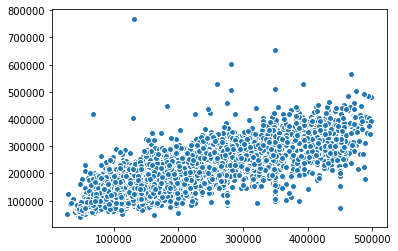

In [42]:
# Our predictions
plt.scatter(y_test,test_predictions, edgecolor='w')

**Error distribution**

In [51]:
np.array(y_test)

array([ 73800., 359100.,  94700., ..., 140600.,  96200., 187500.])

In [52]:
test_predictions.reshape((test_predictions.shape[0]))

array([123779.625, 284532.2  , 101685.97 , ..., 141234.27 , 119725.62 ,
       148026.06 ], dtype=float32)

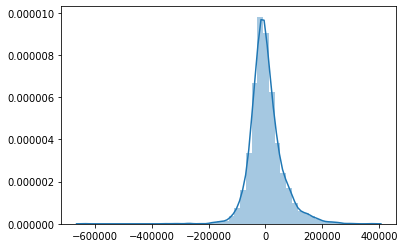

In [53]:
errors = np.array(y_test) - test_predictions.reshape((test_predictions.shape[0]))
sns.distplot(errors)

<a id='predictions'></a>
## Predictions

In [54]:
single_house = df.drop('median_house_value',axis=1).iloc[0]
print("True house priece:", df['median_house_value'].iloc[0])

True house priece: 452600.0


In [55]:
single_house = scaler.transform(single_house.values.reshape(-1, 9))

In [56]:
print("Predicted house priece:", model.predict(single_house)[0][0])

Predicted house priece: 418815.0
